# VGG16: Pretrained using UCF101

According to *Vision-Based Fall Detection with Convolutiona Neural Networks* Article from 2017. In order to create a proper CNN approach, one must:
1. Calculate the OFs of the frames
2. Use these as inputs to a pretrained VGG16 and train it into the Imagenet Class
3. Save that model, and change the first layer so it can receive OFs again, to fit a UCF101 classifation task.
4. Once thats done, take the weights, and change the labels to binary cross entropy to identify falls or not.

Given the situation that computer resources are limited, and retraining on huge datasets like this would be computationally expensive, what we are gonna do is a simple VGG16 finetuned baseline as the following:
1. Divide the dataframe for specific train, test, and validation splits
2. Obtain two loaders, train and test loader.
3. Obtain the VGG16 pretrained on the Imagenet 1k dataset.
4. Change the classifier layer and loss to binary cross entropy,
5. Perform finetuning
6. Calculate the training, test model metrics.

### 1. Lets get the dataframe and split it properly

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from tqdm import tqdm

In [2]:
# See of Data path exists
RAW_DATA_PATH = os.path.join(os.getcwd(), os.pardir, "data", "MultiCamFall")
print(os.path.exists(RAW_DATA_PATH))

OF_DATA_PATH = os.path.join(os.getcwd(), "images")
print(os.path.exists(OF_DATA_PATH))

True
True


In [3]:
#lets obtain the metadata file
df_metadata = pd.read_csv(os.path.join(RAW_DATA_PATH, "data_tuple3.csv"))
df_metadata.loc[df_metadata["cam"] == 55, "cam"] = 3.0

In [4]:
# Get the device if cuda or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Lets split the dataframe into train and test

In [5]:
#After manually finding indices, I found these to be the best to balance training; and the
#Other dataframes to have slight more values for 1s and zeres
df_metadata_train = df_metadata.iloc[int(df_metadata.shape[0] * 0.2):] # 0.2 to 1
df_metadata_val = df_metadata.iloc[:int(df_metadata.shape[0] * 0.1)] # 0 to 0.1
df_metadata_test = df_metadata.iloc[int(df_metadata.shape[0] * 0.1):int(df_metadata.shape[0] * 0.2)] # 0.1 to 0.2

#Print the dimensions of each dataframe
print(df_metadata.shape)
print(df_metadata_train.shape)
print(df_metadata_val.shape)
print(df_metadata_test.shape)
print(int(df_metadata_test.shape[0]*30))

(552, 5)
(442, 5)
(55, 5)
(55, 5)
1650


In [7]:
df_metadata_train.head()

,chute,cam,start,end,label
110,5.0,4.0,320.0,350.0,1.0
111,5.0,4.0,351.0,381.0,0.0
112,5.0,5.0,327.0,357.0,1.0
113,5.0,5.0,358.0,388.0,0.0
114,5.0,6.0,335.0,365.0,1.0


## 3. Lets see the distirbutions of each of the dataframes

Text(0.5, 1.0, 'Test data, distribution of Falls/No falls')

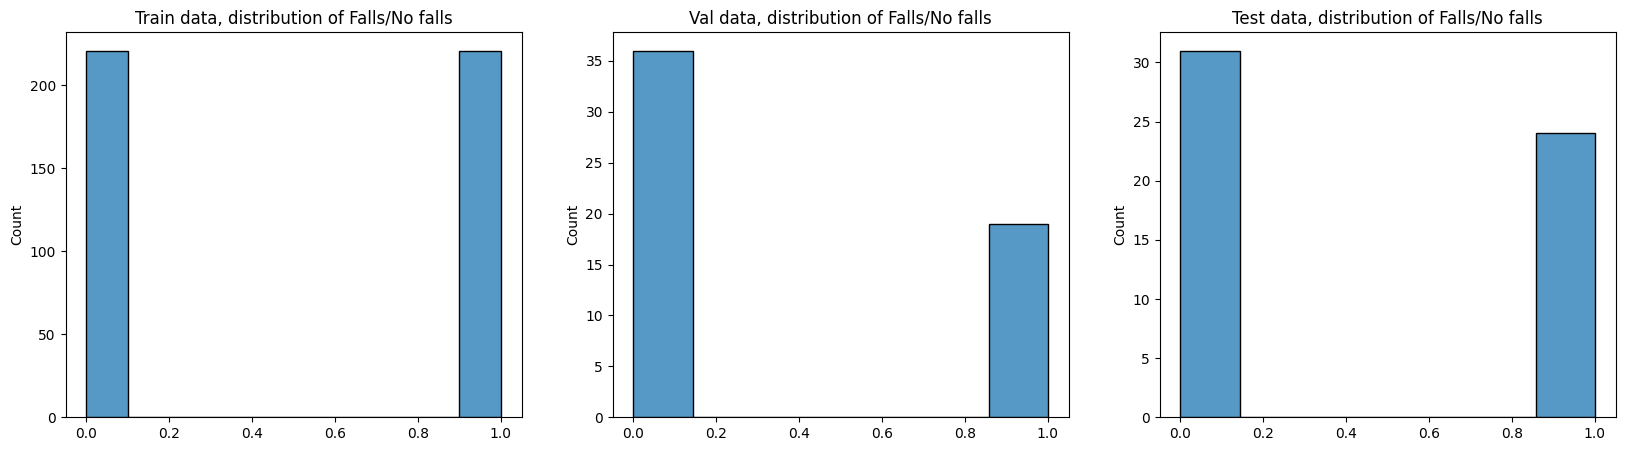

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
sns.histplot(df_metadata_train["label"].to_numpy())
plt.title("Train data, distribution of Falls/No falls")
plt.subplot(1,3,2)
sns.histplot(df_metadata_val["label"].to_numpy())
plt.title("Val data, distribution of Falls/No falls")
plt.subplot(1,3,3)
sns.histplot(df_metadata_test["label"].to_numpy())
plt.title("Test data, distribution of Falls/No falls")

### 4. Lets obtain the Daloaders per frame for each

In [6]:
#Obtain the datasets
train_dataset = utils.FigDatasetFrame(dataframe=df_metadata_train,\
    data_path=OF_DATA_PATH, device=device)
val_dataset = utils.FigDatasetFrame(dataframe=df_metadata_val,\
    data_path=OF_DATA_PATH, device=device)
test_dataset = utils.FigDatasetFrame(dataframe=df_metadata_test,\
    data_path=OF_DATA_PATH, device=device)

#Set a batch_size of 90
batch_size = 90
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

(-0.5, 223.5, 223.5, -0.5)

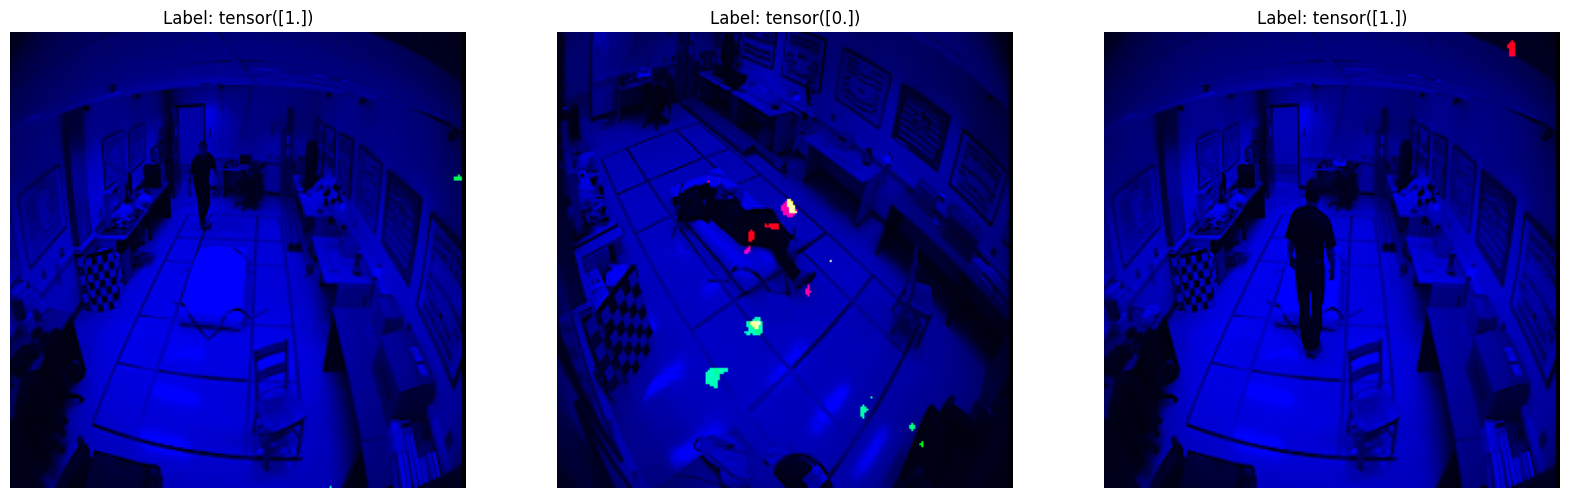

In [ ]:
#Select a plot_idx
plot_idx = 62

#Select three images to see them
__, of_img_train, label_train = train_dataset[plot_idx]
__, of_img_val, label_val = val_dataset[plot_idx]
__, of_img_test, label_test = test_dataset[plot_idx]

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(of_img_train.cpu().numpy().astype(np.uint8))
plt.title(f"Label: {label_train}")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(of_img_val.cpu().numpy().astype(np.uint8))
plt.title(f"Label: {label_val}")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(of_img_test.cpu().numpy().astype(np.uint8))
plt.title(f"Label: {label_test}")
plt.axis("off")

### Lets see if we can load the batches for training and val

In [ ]:
for idx, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc="Processing Batches"):
    __, images, labels = batch
    if idx == 5:
        print(f"Images shape: {images.shape}, Labels: {labels.shape}")
        break

Processing Batches:   3%|▎         | 5/148 [00:36<17:22,  7.29s/it]

Images shape: torch.Size([90, 224, 224, 3]), Labels: torch.Size([90, 1])


In [ ]:
for idx, batch in tqdm(enumerate(val_loader), total=len(val_loader), desc="Processing Batches"):
    __, images, labels = batch
    if idx == 5:
        print(f"Images shape: {images.shape}, Labels: {labels.shape}")
        break

Processing Batches:  26%|██▋       | 5/19 [00:41<01:54,  8.20s/it]

Images shape: torch.Size([90, 224, 224, 3]), Labels: torch.Size([90, 1])


## 5. Lets load our VGGNet16 
We would change the last layer of the classifier, and change it to a binary classification
problem.

In [10]:
# load a pretrained model
vgg16_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

In [11]:
print(vgg16_model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [12]:
print(vgg16_model.avgpool)

AdaptiveAvgPool2d(output_size=(7, 7))


In [13]:
print(vgg16_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


### Lets now set all parameters inside the model to requires grad false

In [14]:
for param in vgg16_model.parameters():
    param.requires_grad = False

### Now lets modify the last classifier layer to only two neurons!

In [15]:
# Modify the last layer for the last 20 classes
num_classes = 1 #We are predicting one singular variable, if its 1 or 0.
num_features = vgg16_model.classifier[-1].in_features

# Replace the last layer with a new fully connected layer
vgg16_model.classifier[-1] = nn.Linear(num_features, num_classes)
print(vgg16_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1, bias=True)
)


In [16]:
# Create models path to save the state_dict_path of our pretrained model
model_path = os.path.join(os.getcwd(), "models")
if os.path.exists(model_path) == False:
    os.mkdir(model_path)

### 4. Now lets create a function that would be used to finetune the model

In [17]:
import torch.optim as optim
# Create a loss fn and optimizer
lr = 0.0001
epochs = 1

#Set up the loss function 
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.1]))

for name, param in vgg16_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.grad is not None}: {param.requires_grad}")

#Set up the optimizer and select only the last two parameters to optimize
params_to_update = [x for x in vgg16_model.classifier[-1].parameters()]
optimizer = optim.Adam(params=params_to_update, lr=lr)

classifier.6.weight: False: True
classifier.6.bias: False: True


In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torcheval.metrics.functional.classification import binary_auroc, binary_precision, binary_recall
# Plot ROC-AUC curve
from sklearn.metrics import roc_curve, auc

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    num_epochs: int,
    device: str,
    optimizer_passed: torch.optim.Optimizer,
    loss_fn_passed: nn.BCEWithLogitsLoss,
    break_idx: int,
    use_image:bool
) -> dict:
    """
    Fine-tunes a model passed and perform the following:

    Parameters:
        model (nn.Module): Any model created to train and validate.
        train_loader (DataLoader): Dataloader for training dataset.
        val_loader (DataLoader): Dataloader for validation dataset.
        num_epochs (int): Number of epochs for training.
        device (str): 'cpu' or 'cuda' device.
        optimizer_passed (torch.optim.Optimizer): Optimizer for updating weights.
        loss_fn_passed (nn.BCEWithLogitsLoss): Binary cross-entropy loss with logits.
        state_dict_path_passed (str): Directory to save trained model states.
        break_idx (int): Early stopping index for debugging.
        use_image(bool): Boolean that selects images instead of Optical flow gradients.

    Returns:
        dict: Training and Validation Losses, 
    """

    results = {
        "train_losses": [],
        "train_auc": [],
        "train_precision": [],
        "train_recall":[],
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        model.train()

        # To hold for all metrics
        train_loss = 0.0
        train_auc = 0.0
        train_precision = 0.0
        train_recall = 0.0

        #Set a pbar for train batch
        pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training batches")

        for idx, batch in pbar_train:
            if use_image == False:
                _, X_batch_train, y_batch_label = batch  # Unpacking batch
            else:
                X_batch_train, _, y_batch_label = batch  # Unpacking batch
            X_batch_train = X_batch_train.permute(0, 3, 1, 2).to(device)
            y_batch_label = y_batch_label.to(device, dtype=torch.float32)

            #1. Do the forward pass
            y_batch_logits = model(X_batch_train)

            #2. Calculate the loss.
            loss = loss_fn_passed(y_batch_logits, y_batch_label)

            #3. Optimizer zero grad
            optimizer_passed.zero_grad()
            
            #4. Step backwards
            loss.backward()

            #5. Optimizer step, step, step
            optimizer_passed.step()

            # Update tqdm description with current loss
            pbar_train.set_description(f"Training Loss: {loss.item()}")

            # Lets obtain the y_batch_probabilities from logits
            y_batch_probs = torch.sigmoid(y_batch_logits)

            # Calculate ROC curve
            fpr, tpr, thresholds = roc_curve(y_batch_label.detach().numpy(), y_batch_probs.detach().numpy())

            # Calculate Youden's J statistic to find optimal threshold
            J = tpr - fpr
            optimal_idx = np.argmax(J)
            optimal_threshold = thresholds[optimal_idx]

            if optimal_threshold == np.inf:
                optimal_threshold = 0.5

            # Lets calculate auc, precision, and recall
            train_auc = binary_auroc(y_batch_probs.squeeze(), y_batch_label.squeeze())
            train_precision = binary_precision(y_batch_probs.squeeze(), y_batch_label.squeeze().to(torch.int), threshold=optimal_threshold)
            train_recall = binary_recall(y_batch_probs.squeeze(), y_batch_label.squeeze().to(torch.int), threshold=optimal_threshold)

            if idx == break_idx:
                break

            #Lets do the same for loss
            train_loss = loss.item()

            # Store training results
            results["train_losses"].append(train_loss)
            results["train_auc"].append(train_auc)
            results["train_precision"].append(train_precision)
            results["train_recall"].append(train_recall)

            pbar_train.set_description(f"epoch: {epoch}; Train Loss: {train_loss:.4f}, Train AUCROC: {train_auc:.4f}, Train Precision: {train_precision:.4f}, Train recall {train_recall:.4f}, threshold: {optimal_threshold:.4f}%")

    return results


In [22]:
import torch
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import roc_curve

def validate_model(model, val_loader, device, loss_fn, state_dict_path, num_epochs, break_idx, use_image=False):
    """
    Perform validation for a given model and save the best model based on validation loss.
    
    Args:
        model (torch.nn.Module): The model to validate.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        device (torch.device): The device to run the model on (CPU/GPU).
        loss_fn (callable): Loss function.
        state_dict_path (str): Path to save the best model.
        num_epochs (int): Number of validation epochs.
        break_idx (int): Index to break validation early for debugging.
        use_image (bool, optional): Whether the input includes image data. Default is False.

    Returns:
        dict: Dictionary containing validation losses, AUC, precision, and recall per batch.
    """
    model.eval()
    best_val_loss = float('inf')
    results = {"val_losses": [],
            "val_auc": [],
            "val_precision": [],
            "val_recall": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}\n" + "-" * 30)
        pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation batches")

        with torch.inference_mode():
            for idx, batch in pbar_val:
                if not use_image:
                    _, X_batch_val, y_batch_val = batch
                else:
                    X_batch_val, _, y_batch_val = batch
                
                X_batch_val = X_batch_val.permute(0, 3, 1, 2).to(device)
                y_batch_val = y_batch_val.to(device, dtype=torch.float32)

                # Forward pass
                y_val_logits = model(X_batch_val)
                loss = loss_fn(y_val_logits, y_batch_val)
                y_val_probs = torch.sigmoid(y_val_logits)

                # Calculate validation metrics
                val_loss = loss.item()
                fpr, tpr, thresholds = roc_curve(y_batch_val.cpu().numpy(), y_val_probs.cpu().numpy())
                J = tpr - fpr
                optimal_idx = np.argmax(J)
                optimal_threshold = thresholds[optimal_idx] if thresholds[optimal_idx] != np.inf else 0.5
                
                val_auc = binary_auroc(y_val_probs.squeeze(), y_batch_val.squeeze())
                val_precision = binary_precision(y_val_probs.squeeze(), y_batch_val.squeeze().to(torch.int), threshold=optimal_threshold)
                val_recall = binary_recall(y_val_probs.squeeze(), y_batch_val.squeeze().to(torch.int), threshold=optimal_threshold)
                
                # Store results
                results["val_losses"].append(val_loss)
                results["val_auc"].append(val_auc)
                results["val_precision"].append(val_precision)
                results["val_recall"].append(val_recall)

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_path = os.path.join(state_dict_path, "best_vgg16_finetuned.pth")
                    if os.path.exists(best_model_path):
                        os.remove(best_model_path)
                    torch.save(model.state_dict(), best_model_path)
                    print(f"Best model saved to {best_model_path}")
                
                # Break early if specified
                if idx == break_idx:
                    break

                pbar_val.set_description(f"epoch: {epoch}; Val Loss: {val_loss:.4f}, Val AUCROC: {val_auc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Threshold: {optimal_threshold:.4f}")
    
    return results

In [23]:
#Train the model
train_results = train_model(model=vgg16_model, train_loader=train_loader,\
    num_epochs=epochs, device=device, optimizer_passed=optimizer, loss_fn_passed= loss_fn,\
    break_idx= 1000000, use_image = False)


Epoch 1/1
------------------------------


epoch: 0; Train Loss: 1.8956, Train AUCROC: 0.5567, Train Precision: 0.6111, Train recall 0.4681, threshold: 0.6838%: 100%|██████████| 147/147 [29:31<00:00, 12.05s/it]


### 5. Plot the Train results

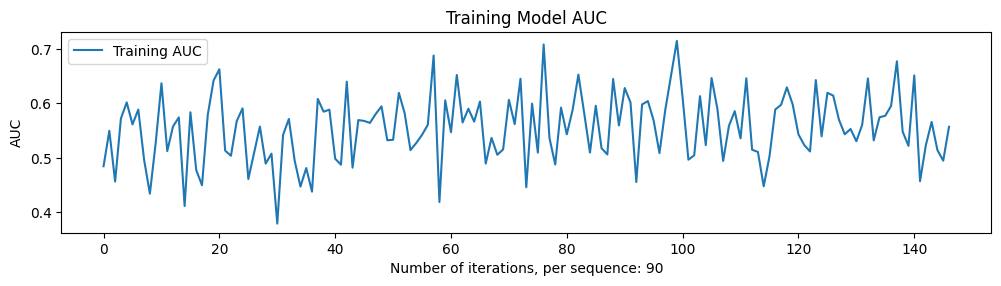

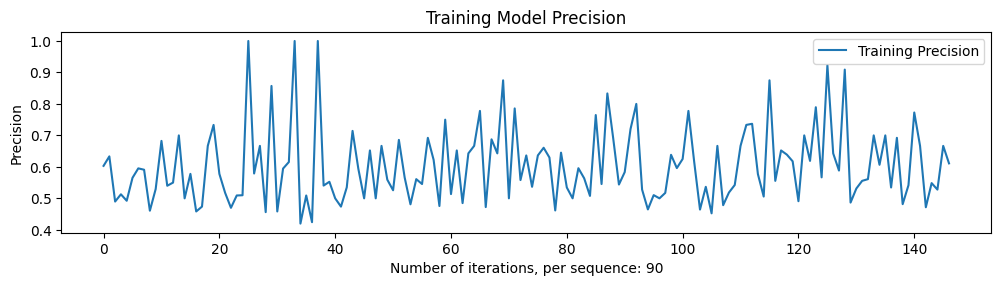

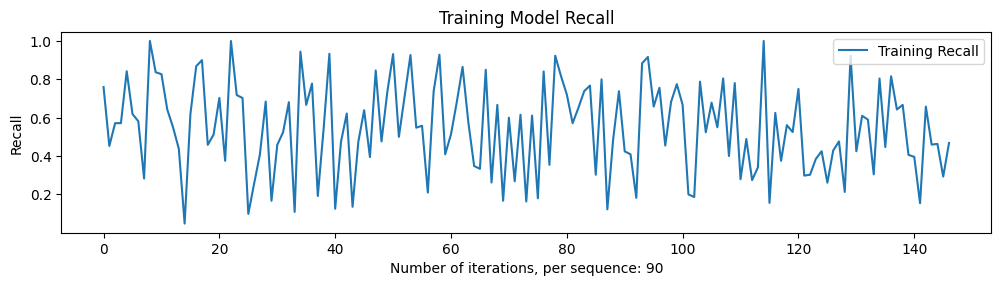

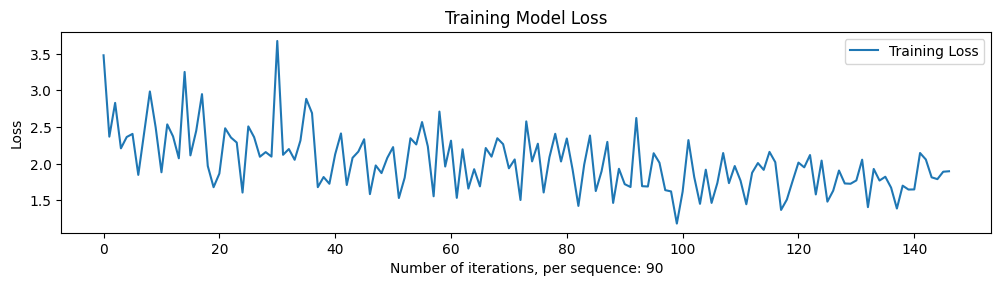

In [24]:
# Plot training & validation AUC
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(train_results['train_auc'], label='Training AUC')
plt.title('Training Model AUC')
plt.xlabel(f'Number of iterations, per sequence: {batch_size}')
plt.ylabel('AUC')
plt.legend()

plt.figure(figsize=(12, 12))
# Plot training & validation precision
plt.subplot(4, 1, 2)
plt.plot(train_results['train_precision'], label='Training Precision')
plt.title('Training Model Precision')
plt.xlabel(f'Number of iterations, per sequence: {batch_size}')
plt.ylabel('Precision')
plt.legend()

# Plot training & validation recall
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 3)
plt.plot(train_results['train_recall'], label='Training Recall')
plt.title('Training Model Recall')
plt.xlabel(f'Number of iterations, per sequence: {batch_size}')
plt.ylabel('Recall')
plt.legend()

# Plot training & validation loss
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 4)
plt.plot(train_results['train_losses'], label='Training Loss')
plt.title('Training Model Loss')
plt.xlabel(f'Number of iterations, per sequence: {batch_size}')
plt.ylabel('Loss')
plt.legend()

### 6. Obtain the validation results

In [25]:
#Train the model
val_results = validate_model(model=vgg16_model, val_loader=val_loader, device = device,\
    loss_fn=loss_fn, state_dict_path=model_path,\
    num_epochs=1, break_idx=1000000, use_image=False)


Epoch 1/1
------------------------------


epoch: 0; Val Loss: 0.9895, Val AUCROC: 0.4694, Val Precision: 0.5500, Val Recall: 0.3667, Threshold: 0.7913:   3%|▎         | 1/37 [00:20<12:01, 20.03s/it]

Best model saved to c:\Users\ajedr\OneDrive\Documentos\University_San_Diego_2024_2026\Masters_AI_Workspace\src\ElderSafeAI\CNN\models\best_vgg16_finetuned.pth


c:\Users\ajedr\OneDrive\Documentos\University_San_Diego_2024_2026\Masters_AI_Workspace\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
epoch: 0; Val Loss: 0.6973, Val AUCROC: 0.5000, Val Precision: 1.0000, Val Recall: 0.4667, Threshold: 0.5000:   5%|▌         | 2/37 [00:30<08:23, 14.39s/it]

Best model saved to c:\Users\ajedr\OneDrive\Documentos\University_San_Diego_2024_2026\Masters_AI_Workspace\src\ElderSafeAI\CNN\models\best_vgg16_finetuned.pth


epoch: 0; Val Loss: 0.5205, Val AUCROC: 0.8517, Val Precision: 0.5686, Val Recall: 0.9667, Threshold: 0.3698:   8%|▊         | 3/37 [00:42<07:33, 13.33s/it]

Best model saved to c:\Users\ajedr\OneDrive\Documentos\University_San_Diego_2024_2026\Masters_AI_Workspace\src\ElderSafeAI\CNN\models\best_vgg16_finetuned.pth


c:\Users\ajedr\OneDrive\Documentos\University_San_Diego_2024_2026\Masters_AI_Workspace\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
epoch: 0; Val Loss: 0.9656, Val AUCROC: 0.5056, Val Precision: 0.4085, Val Recall: 0.9667, Threshold: 0.1676:  14%|█▎        | 5/37 [01:06<06:44, 12.64s/it]c:\Users\ajedr\OneDrive\Documentos\University_San_Diego_2024_2026\Masters_AI_Workspace\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
epoch: 0; Val Loss: 1.9910, Val AUCROC: 0.1122, Val Precision: 0.0600, Val Recall: 0.1000, Threshold: 0.5000:  19%|█▉        | 7/37 [01:32<06:22, 12.74s/it]c:\Users\ajedr\OneDrive\Documentos\University_San_Diego_2024_2026\Masters_AI_Workspace\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No

Best model saved to c:\Users\ajedr\OneDrive\Documentos\University_San_Diego_2024_2026\Masters_AI_Workspace\src\ElderSafeAI\CNN\models\best_vgg16_finetuned.pth


epoch: 0; Val Loss: 0.8077, Val AUCROC: 0.6844, Val Precision: 0.7222, Val Recall: 0.4333, Threshold: 0.2100: 100%|██████████| 37/37 [07:56<00:00, 12.88s/it]


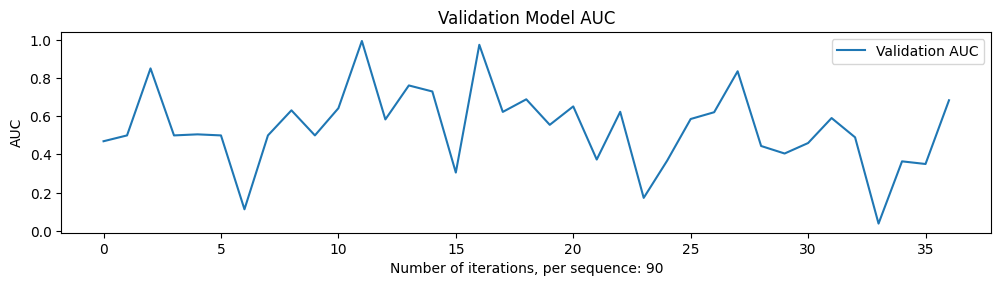

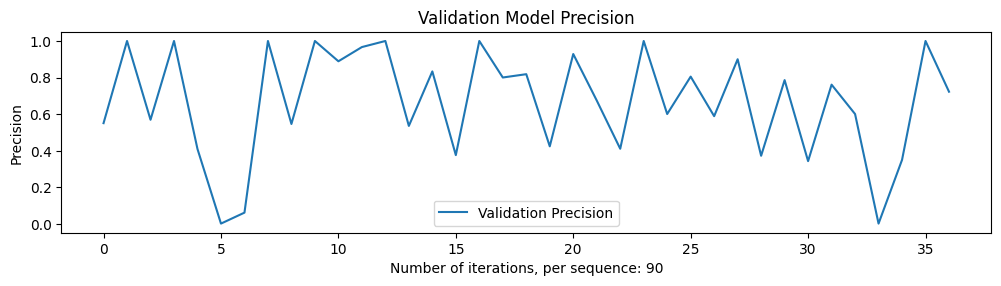

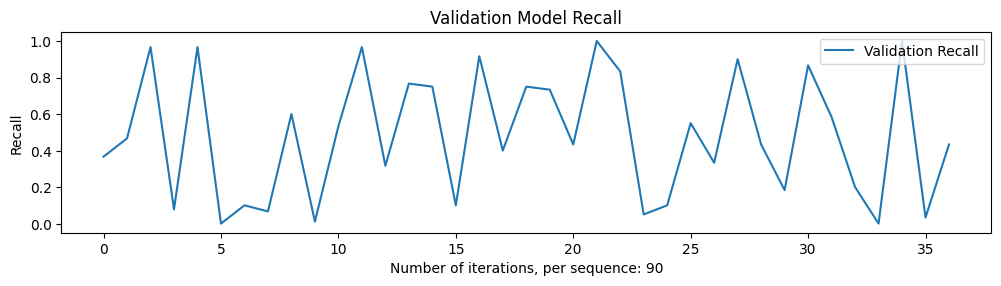

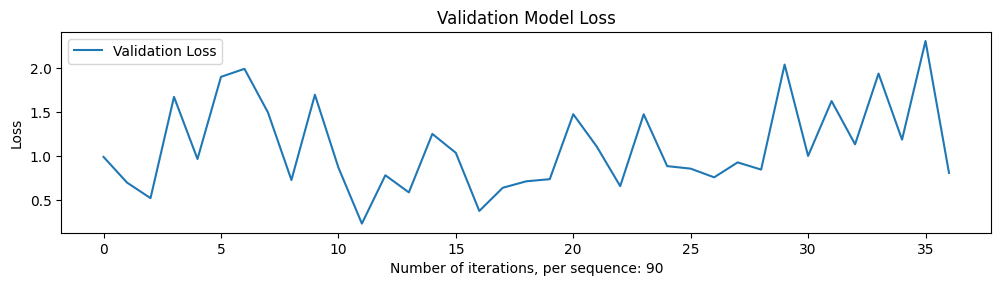

In [26]:
# Plot training & validation AUC
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(val_results['val_auc'], label='Validation AUC')
plt.title('Validation Model AUC')
plt.xlabel(f'Number of iterations, per sequence: {batch_size}')
plt.ylabel('AUC')
plt.legend()

plt.figure(figsize=(12, 12))
# Plot training & validation precision
plt.subplot(4, 1, 2)
plt.plot(val_results['val_precision'], label='Validation Precision')
plt.title('Validation Model Precision')
plt.xlabel(f'Number of iterations, per sequence: {batch_size}')
plt.ylabel('Precision')
plt.legend()

# Plot training & validation recall
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 3)
plt.plot(val_results['val_recall'], label='Validation Recall')
plt.title('Validation Model Recall')
plt.xlabel(f'Number of iterations, per sequence: {batch_size}')
plt.ylabel('Recall')
plt.legend()

# Plot training & validation loss
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 4)
plt.plot(val_results['val_losses'], label='Validation Loss')
plt.title('Validation Model Loss')
plt.xlabel(f'Number of iterations, per sequence: {batch_size}')
plt.ylabel('Loss')
plt.legend()

Test batches:   0%|          | 0/5 [00:00<?, ?it/s]

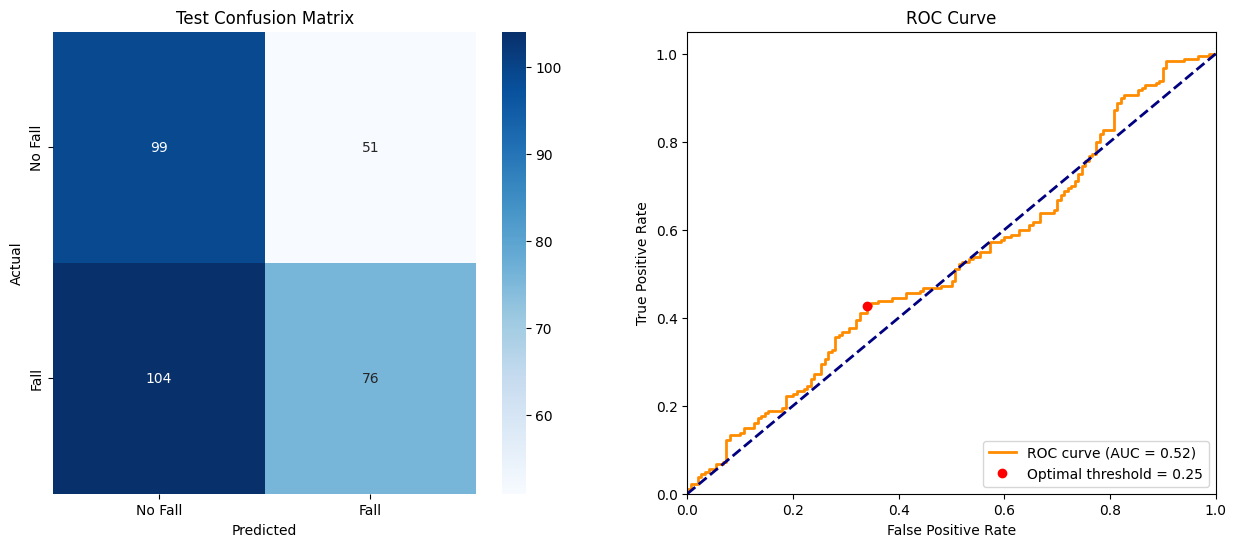

Test batches:  20%|██        | 1/5 [01:20<05:21, 80.26s/it]

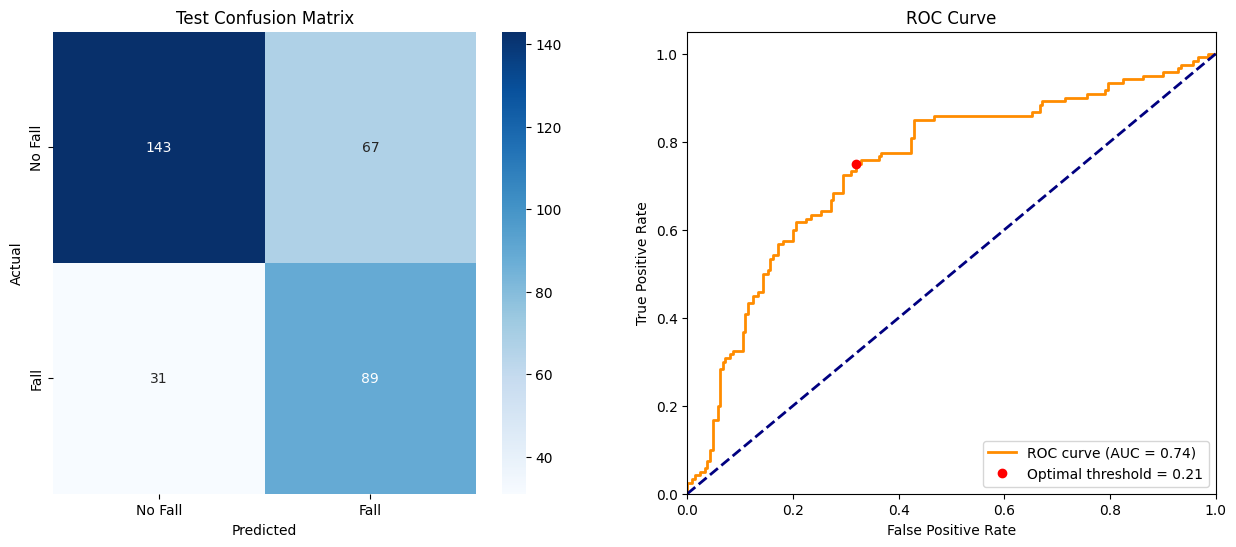

Test batches:  40%|████      | 2/5 [02:01<02:51, 57.18s/it]

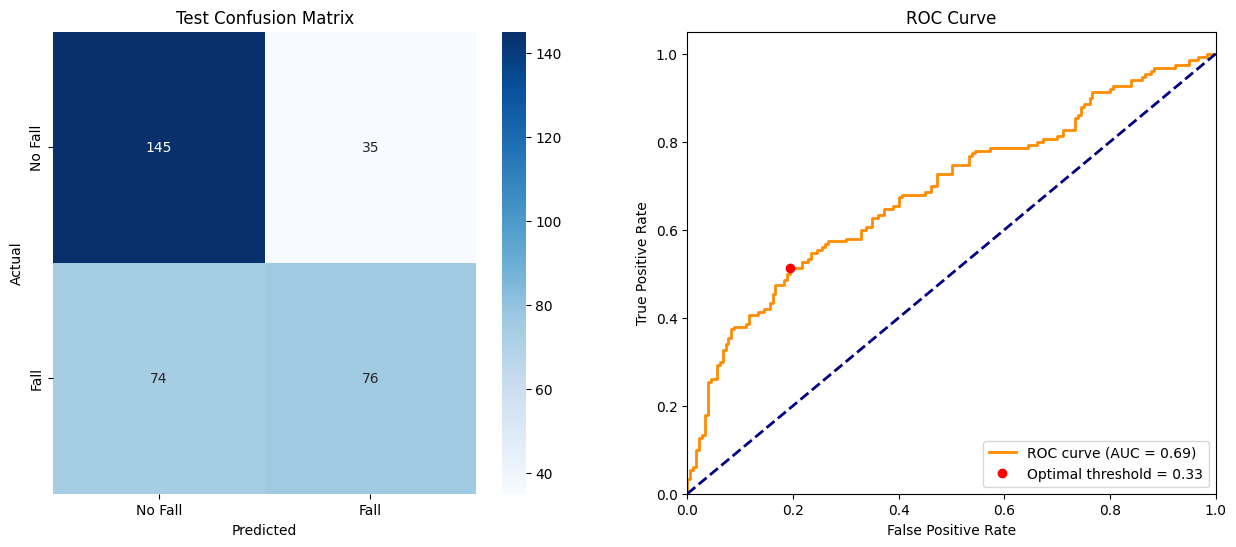

Test batches:  60%|██████    | 3/5 [02:42<01:39, 49.80s/it]

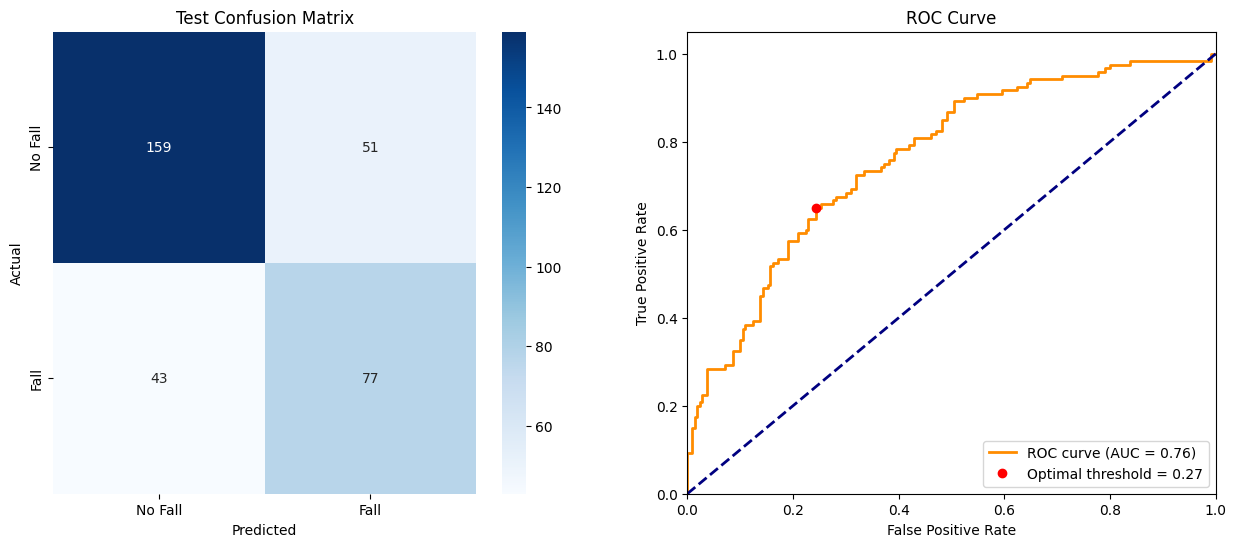

Test batches:  80%|████████  | 4/5 [03:21<00:45, 45.70s/it]

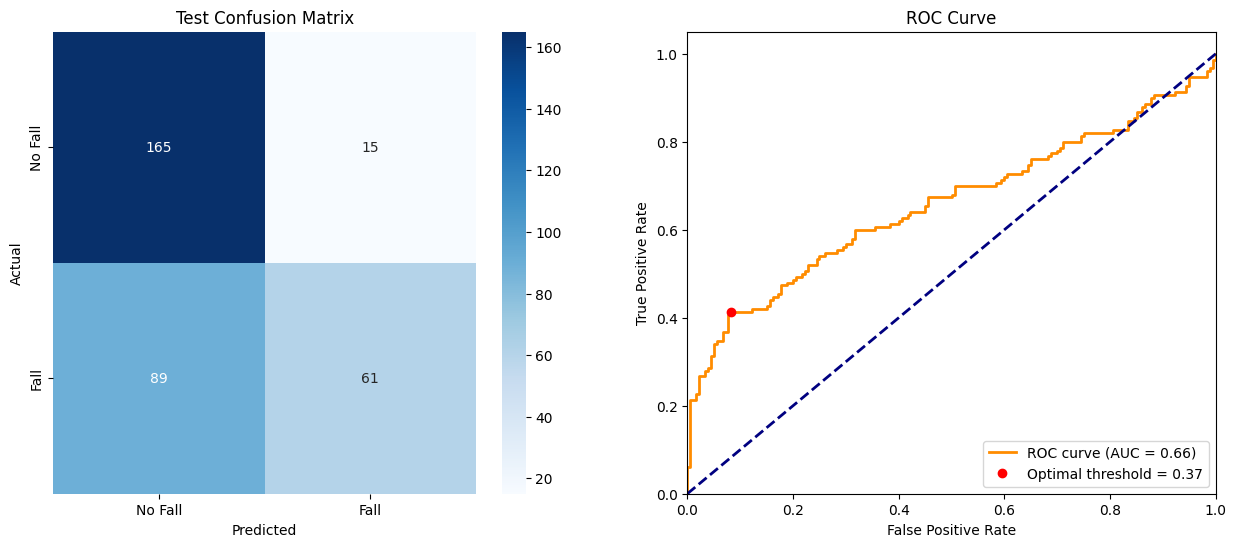

Test batches: 100%|██████████| 5/5 [03:59<00:00, 47.95s/it]


In [18]:
# Plot ROC-AUC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Get prediction probabilities
vgg16_model.load_state_dict(torch.load(os.path.join(model_path, "best_vgg16_finetuned.pth"), weights_only=True))
vgg16_model.eval()

#Simple test confusion matrices for batch_size = 330
test_loader = DataLoader(test_dataset, batch_size=330, shuffle=False, num_workers=1)
pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Test batches")
use_image = False

#Have two holders to obtain the final confusion matrix
final_test_predictions = []
final_test_actual = []

with torch.inference_mode():
    for idx, batch in pbar_test:
        if not use_image:
            _, X_batch_test, y_batch_test = batch
        else:
            X_batch_test, _, y_batch_test = batch
        
        X_batch_test = X_batch_test.permute(0, 3, 1, 2).to(device)
        y_batch_test = y_batch_test.to(device, dtype=torch.float32)

        # Forward pass
        y_test_logits = vgg16_model(X_batch_test)
        loss = loss_fn(y_test_logits, y_batch_test)
        y_test_probs = torch.sigmoid(y_test_logits)

        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_batch_test.detach().numpy(), y_test_probs.detach().numpy())
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve and find optimal threshold
        # Calculate Youden's J statistic to find optimal threshold
        J = tpr - fpr
        optimal_idx = np.argmax(J)
        optimal_threshold = thresholds[optimal_idx]

        # Generate predictions
        test_predictions = (y_test_probs.detach().numpy() > optimal_threshold).astype(int)  # Convert to binary predictions using optimal threshold

        # Compute confusion matrix
        cm = confusion_matrix(y_batch_test.detach().numpy(), test_predictions)

        #Append them properly
        final_test_predictions.append(test_predictions)
        final_test_actual.append(y_batch_test.detach().numpy())

        # Plot confusion matrix
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fall", "Fall"], yticklabels=["No Fall", "Fall"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Test Confusion Matrix")

        # Plot ROC curve
        plt.subplot(1, 2 ,2)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label=f'Optimal threshold = {optimal_threshold:.2f}')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

### OBTAIN the final Confusion Matrix

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Compute detailed metrics
print("Classification Report:")
print(classification_report(np.concatenate(final_test_actual), np.concatenate(final_test_predictions), target_names=["No Fall", "Fall"]))

# Compute ROC-AUC
roc_auc = roc_auc_score(np.concatenate(final_test_actual), np.concatenate(final_test_predictions))
print(f"ROC-AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

     No Fall       0.68      0.76      0.72       930
        Fall       0.63      0.53      0.58       720

    accuracy                           0.66      1650
   macro avg       0.65      0.65      0.65      1650
weighted avg       0.66      0.66      0.66      1650

ROC-AUC Score: 0.6455


Text(0.5, 1.0, 'Total Test Confusion Matrix')

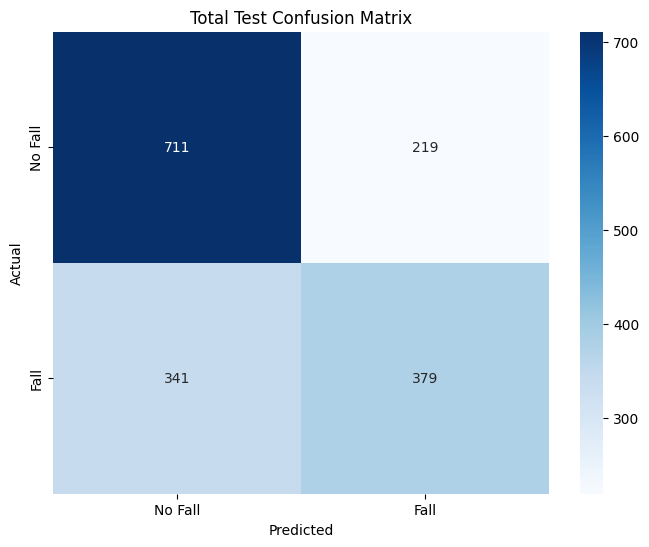

In [20]:
# Compute Final confusion matrix
cm = confusion_matrix(np.concatenate(final_test_actual), np.concatenate(final_test_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fall", "Fall"], yticklabels=["No Fall", "Fall"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Total Test Confusion Matrix")